# <font color=40534C size="6.5">**Building an Image Similarity Search Engine with FAISS & CLIP**</font>

<font color=40534C>**Install & import Requirements**</font>

In [1]:
!pip install sentence-transformers
# !pip install faiss-gpu


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [3]:
# !git clone https://github.com/facebookresearch/faiss.git

In [4]:
# %cd /content/faiss

In [5]:
import os
from glob import glob
from PIL import Image
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import random
import os
import glob
import torch
import open_clip
from PIL import Image
import numpy as np


<font color=40534C size="5.5">**Step 1 - Explore the Data**</font>

<font color=40534C>**Get the dataset and extract the zip file:**</font>

In [6]:
# !wget -O data.zip https://drive.usercontent.google.com/download?id=1q3dpti5aX4LdD3Mq7bZ4rjTeZbQEljiy&export=download&authuser=0
# !unzip "data.zip"

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%pwd

'/content'

<font color=40534C>**Display random images from the dataset:**</font>

image_files :  ['/content/drive/MyDrive/train_from_scratch/GroundNut/VT_DATASET/GROUND_NUT_UNIQUE/aphids/aphids_00245.jpg', '/content/drive/MyDrive/train_from_scratch/GroundNut/VT_DATASET/GROUND_NUT_UNIQUE/aphids/aphids_00679.jpg', '/content/drive/MyDrive/train_from_scratch/GroundNut/VT_DATASET/GROUND_NUT_UNIQUE/aphids/aphids_00807.jpg', '/content/drive/MyDrive/train_from_scratch/GroundNut/VT_DATASET/GROUND_NUT_UNIQUE/aphids/aphids_00429.jpg', '/content/drive/MyDrive/train_from_scratch/GroundNut/VT_DATASET/GROUND_NUT_UNIQUE/aphids/aphids_00425.jpg', '/content/drive/MyDrive/train_from_scratch/GroundNut/VT_DATASET/GROUND_NUT_UNIQUE/aphids/aphids_00299.jpg', '/content/drive/MyDrive/train_from_scratch/GroundNut/VT_DATASET/GROUND_NUT_UNIQUE/aphids/aphids_00786.jpg', '/content/drive/MyDrive/train_from_scratch/GroundNut/VT_DATASET/GROUND_NUT_UNIQUE/aphids/aphids_00585.jpg', '/content/drive/MyDrive/train_from_scratch/GroundNut/VT_DATASET/GROUND_NUT_UNIQUE/aphids/aphids_00566.jpg', '/content/dr

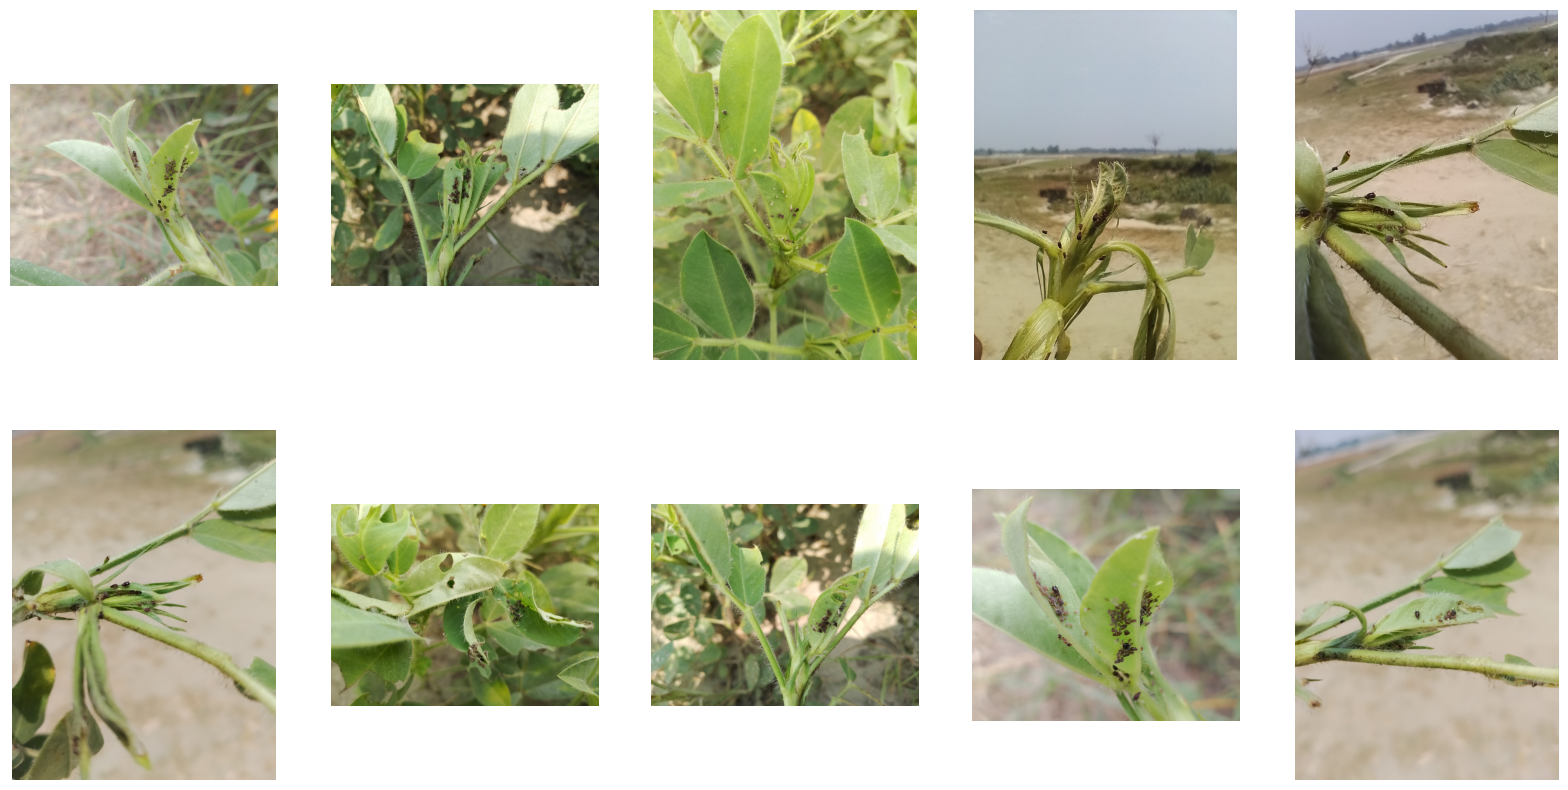

In [9]:
import os
import glob
import random
import matplotlib.pyplot as plt
from PIL import Image

image_folder = '/content/drive/MyDrive/train_from_scratch/GroundNut/VT_DATASET/GROUND_NUT_UNIQUE/aphids/'

# Get a list of all image files in the folder
image_files = glob.glob(os.path.join(image_folder, '*.jpg'))  # Use glob.glob instead of glob()
print("image_files : ",image_files)
# Check if there are enough images
num_images = len(image_files)
if num_images < 10:
    print(f"Only {num_images} images found, selecting all available images.")
    selected_images = image_files  # Select all available images
else:
    random.seed(42)
    selected_images = random.sample(image_files, 10)

# Display the selected images
plt.figure(figsize=(20, 10))
for i, image_path in enumerate(selected_images):
    img = Image.open(image_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [10]:
!pip install open-clip-torch


In [11]:

import torch
import open_clip

# Load CLIP model correctly
model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai")

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)  # Now 'model' is correctly assigned

print("CLIP model and preprocessing function loaded successfully.")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:380: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


CLIP model and preprocessing function loaded successfully.


In [28]:
tokenizer = open_clip.get_tokenizer("ViT-B-32")

In [12]:


def generate_clip_embeddings(images_path, model, preprocess):
    image_paths = glob.glob(os.path.join(images_path, '*.jpg'))  # Get all JPG files
    print(f"Found {len(image_paths)} images in {images_path}")

    embeddings = []
    for img_path in image_paths:
        image = Image.open(img_path).convert("RGB")
        image = preprocess(image).unsqueeze(0).to(device)  # Preprocess and move to GPU/CPU

        with torch.no_grad():
            embedding = model.encode_image(image).cpu().numpy()  # Get CLIP embedding

        embeddings.append(embedding)

    return np.array(embeddings), image_paths

# Define image folder and generate embeddings
IMAGES_PATH = "/content/drive/MyDrive/train_from_scratch/GroundNut/VT_DATASET/GROUND_NUT_UNIQUE/aphids/"
embeddings, image_paths = generate_clip_embeddings(IMAGES_PATH, model, preprocess)

# Print shape of embeddings
print(f"Generated embeddings shape: {embeddings.shape}")



Found 699 images in /content/drive/MyDrive/train_from_scratch/GroundNut/VT_DATASET/GROUND_NUT_UNIQUE/aphids/
Generated embeddings shape: (699, 1, 512)


<font color=40534C size="5.5">**Step 2 - Generate CLIP embeddings**</font>

<font color=40534C size="5.5">**Step 3 - Generate FAISS Index with Image Embeddings**</font>

In [14]:
!pip install faiss-cpu

In [17]:
# Inspect embeddings to check structure
print(f"Type of embeddings: {type(embeddings)}")
print(f"Length of embeddings: {len(embeddings)}")

# Check the shape of the first embedding
if len(embeddings) > 0:
    print(f"Shape of the first embedding: {np.array(embeddings[0]).shape}")


Type of embeddings: <class 'numpy.ndarray'>
Length of embeddings: 699
Shape of the first embedding: (1, 512)


In [18]:
import numpy as np

# Ensure embeddings is a 2D numpy array
vectors = np.array(embeddings).astype(np.float32)

# Check the shape of vectors
print(f"Shape of vectors: {vectors.shape}")

# If vectors are not 2D (num_embeddings, embedding_dimension), reshape them
if len(vectors.shape) == 1:
    vectors = vectors.reshape(-1, 1)  # Reshape to 2D if needed

print(f"Reshaped vectors shape: {vectors.shape}")


Shape of vectors: (699, 1, 512)
Reshaped vectors shape: (699, 1, 512)


<font color=40534C>**Create and Save FAISS Index:**</font>



In [20]:
import faiss
import numpy as np

def create_faiss_index(embeddings, image_paths, output_path):
    # Convert embeddings into a 2D numpy array and remove the extra dimension
    vectors = np.array(embeddings).astype(np.float32)

    # Check the shape of vectors before reshaping
    print(f"Shape of vectors before reshaping: {vectors.shape}")

    # Reshape to remove the extra dimension (from (699, 1, 512) to (699, 512))
    vectors = vectors.squeeze(axis=1)

    # Check the shape after reshaping
    print(f"Shape of vectors after reshaping: {vectors.shape}")

    # Create the index with L2 distance
    dimension = vectors.shape[1]  # Number of dimensions per vector (512 in this case)
    index = faiss.IndexFlatL2(dimension)
    index = faiss.IndexIDMap(index)

    # Add vectors to the index with IDs (IDs should be a 1D array)
    ids = np.array(range(len(embeddings)))  # ID for each vector (0, 1, 2, ...)
    index.add_with_ids(vectors, ids)  # Ensure shapes are (num_vectors, dimension) and (num_vectors,)

    # Save the index to a file
    faiss.write_index(index, output_path)
    print(f"Index created and saved to {output_path}")

    # Save image paths to a separate file
    with open(output_path + '.paths', 'w') as f:
        for img_path in image_paths:
            f.write(img_path + '\n')

    return index

# Example usage
OUTPUT_INDEX_PATH = "/content/vector.index"
index = create_faiss_index(embeddings, image_paths, OUTPUT_INDEX_PATH)


Shape of vectors before reshaping: (699, 1, 512)
Shape of vectors after reshaping: (699, 512)
Index created and saved to /content/vector.index


<font color=40534C>**Load FAISS index:**</font>



In [21]:
def load_faiss_index(index_path):
    index = faiss.read_index(index_path)
    with open(index_path + '.paths', 'r') as f:
        image_paths = [line.strip() for line in f]
    print(f"Index loaded from {index_path}")
    return index, image_paths

index, image_paths = load_faiss_index(OUTPUT_INDEX_PATH)

Index loaded from /content/vector.index


<font color=40534C>**A function to retrive images with Text or Image query:**</font>



In [22]:
def retrieve_similar_images(query, model, index, image_paths, top_k=3):

    if query.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        query = Image.open(query)

    query_features = model.encode(query)
    query_features = query_features.astype(np.float32).reshape(1, -1)

    distances, indices = index.search(query_features, top_k)

    retrieved_images = [image_paths[int(idx)] for idx in indices[0]]

    return query, retrieved_images

<font color=40534C>**An helper function to display results:**</font>



In [23]:
def visualize_results(query, retrieved_images):
    plt.figure(figsize=(12, 5))

    # If image query
    if isinstance(query, Image.Image):
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.imshow(query)
        plt.title("Query Image")
        plt.axis('off')
        start_idx = 2

    # If text query
    else:
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.text(0.5, 0.5, f"Query:\n\n '{query}'", fontsize=16, ha='center', va='center')
        plt.axis('off')
        start_idx = 2

    # Display images
    for i, img_path in enumerate(retrieved_images):

        plt.subplot(1, len(retrieved_images) + 1, i + start_idx)
        plt.imshow(Image.open(img_path))
        plt.title(f"Match {i + 1}")
        plt.axis('off')

    plt.show()

<font color=40534C>**Search with a Text Query:**</font>



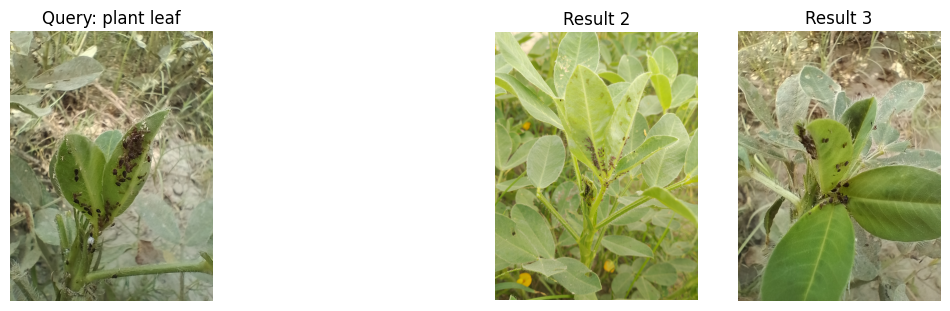

In [29]:
import torch
import numpy as np
import faiss
from PIL import Image
import open_clip
import matplotlib.pyplot as plt

def encode_text(model, query, device):
    # Tokenize and encode the text query
    text = tokenizer([query]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text)
    return text_features

def encode_image(model, image, preprocess, device):
    # Preprocess and encode the image
    image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
    return image_features

def retrieve_similar_images(query, model, index, image_paths, preprocess, device, top_k=3):
    # Encode the text query
    query_embedding = encode_text(model, query, device)

    # Search the FAISS index for the top_k most similar images
    query_embedding = query_embedding.cpu().numpy().astype(np.float32)  # Convert to numpy
    D, I = index.search(query_embedding, top_k)

    # Get the image paths corresponding to the top-k results
    retrieved_images = [image_paths[i] for i in I[0]]

    return query, retrieved_images

def visualize_results(query, retrieved_images):
    # Visualize the query and retrieved images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(Image.open(retrieved_images[0]))  # Display the most similar image
    plt.title(f"Query: {query}")
    plt.axis('off')

    for i, img_path in enumerate(retrieved_images):
        if i == 0:
            continue  # Skip the first image as it is already shown as the most similar one
        plt.subplot(1, 4, i + 2)
        plt.imshow(Image.open(img_path))
        plt.title(f"Result {i + 1}")
        plt.axis('off')

    plt.show()

# Example Usage
query = 'plant leaf'
query, retrieved_images = retrieve_similar_images(query, model, index, image_paths, preprocess, device, top_k=3)
visualize_results(query, retrieved_images)


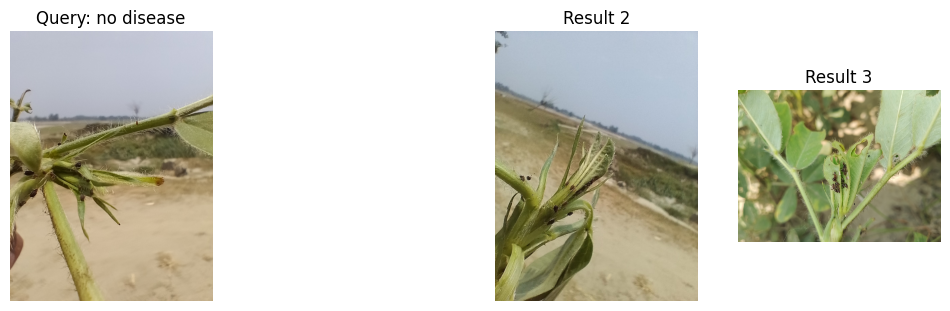

In [34]:
# Example Usage
query = 'no disease'
query, retrieved_images = retrieve_similar_images(query, model, index, image_paths, preprocess, device, top_k=3)
visualize_results(query, retrieved_images)


<font color=40534C>**Search with a Reference Image:**</font>



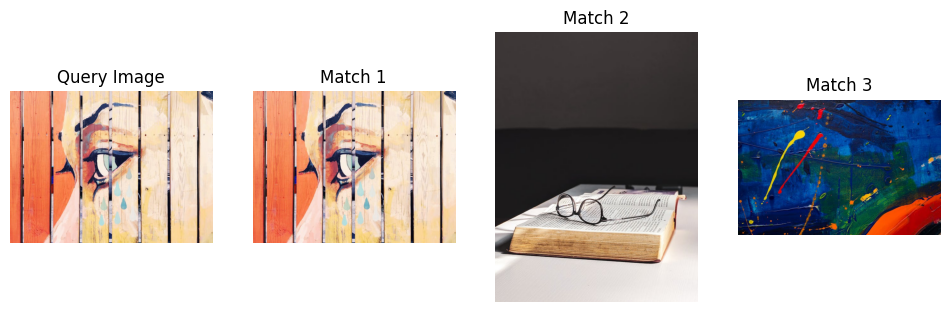

In [ ]:
query = '/content/image_dataset/pexels-w-w-299285-889839.jpg'
query, retrieved_images = retrieve_similar_images(query, model, index, image_paths, top_k=3)
visualize_results(query, retrieved_images)